In [1]:
name_subj = "S7"

import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reading raw BDF, setting up bipolar references and montage

In [2]:
raw = mne.io.read_raw_bdf('../raw_data/%s.bdf'%name_subj,preload=True, verbose=True)

Extracting EDF parameters from /media/gabriel/DATA/ForceEEG/raw_data/S7.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4881407  =      0.000 ...  4766.999 secs...


In [3]:
mne.set_bipolar_reference(raw,anode=['EXG1','EXG3','EXG5','EXG7'],cathode=['EXG2','EXG4','EXG6','Fp2'],ch_name=['EMG_L','EMG_R','EOGH','EOGV'],copy=False, drop_refs=False) #fixe les références bipolaires pour les électrodes externes
raw.set_channel_types({'EMG_L':'emg','EMG_R':'emg','EOGH':'eog','EOGV':'eog','EXG8':'misc','Erg1':'misc','Erg2':'misc'}) #Détermine les types de canaux 
raw.set_eeg_reference(['EXG8']) #référence eeg  mastoide gauche
raw.drop_channels(['EXG1','EXG3','EXG5','EXG7','EXG2','EXG4','EXG6'])

Bipolar channel added as "EMG_L".
Bipolar channel added as "EMG_R".
Bipolar channel added as "EOGH".
Bipolar channel added as "EOGV".
EEG channel type selected for re-referencing
Applying a custom EEG reference.


<RawEDF | S7.bdf, 72 x 4881408 (4767.0 s), ~2.62 GB, data loaded>

## Montage

Here I recover the measurment made using ElGuide, however I only use one file (.sfp) from the three generated by subject, but it seems to be OK.

In [4]:
EEGhead_pos = pd.read_csv('../raw_data/data_ForceEEG_Montage/%s_Force_EEG.sfp'%name_subj,skiprows=3, sep="\t", index_col=0,header=None,usecols=[0,3,5,7])/1000 #mm scale
ref_pos = pd.read_csv('../raw_data/data_ForceEEG_Montage/%s_Force_EEG.sfp'%name_subj,skiprows=0, sep="\t", index_col=0,header=None,usecols=[0,3,6,9],nrows=3)/1000 #mm scale

EEGhead_pos = EEGhead_pos[(np.abs(EEGhead_pos[3]) < (np.std(EEGhead_pos[3])*8))]#removes weird postiion samples larger than 8sd

EEGkeys = EEGhead_pos[:64].index
EEGvalues = np.asarray(EEGhead_pos[:64].reset_index(drop=True))
EEG_points = dict(zip(EEGkeys, EEGvalues))

left, nasion, right = ref_pos.loc["fidt9"].values,ref_pos.loc["fidnz"].values,ref_pos.loc["fidt10"].values #Check LR correctness
head_points = np.asarray(EEGhead_pos[64:].reset_index(drop=True))

dig_montage = mne.channels.make_dig_montage(ch_pos=EEG_points, nasion=nasion, lpa=left, rpa=right, 
                                            hsp=head_points, hpi=None, coord_frame='head')

### Plotting sensor locations

Creating RawArray with float64 data, n_channels=64, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


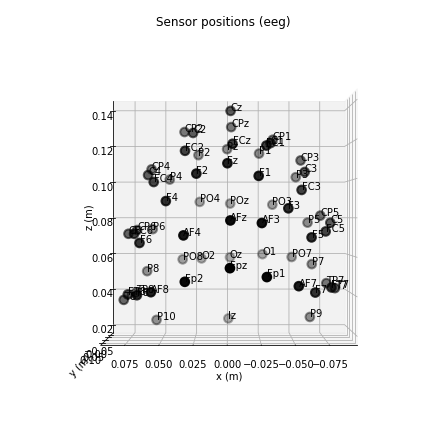

In [5]:
dig_montage.plot(kind='3d');


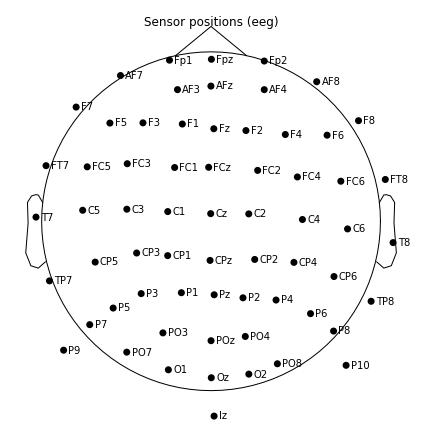

In [6]:
raw.set_montage(dig_montage)
raw.plot_sensors(show_names=True);

# Low-pass filtering

In [7]:
raw.filter(None, 100, None,l_trans_bandwidth='auto',filter_length='auto',phase='zero') #filtre les données entre 0.01 et 100 Hz


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 135 samples (0.132 sec)



<RawEDF | S7.bdf, 72 x 4881408 (4767.0 s), ~2.62 GB, data loaded>

## Checking for bad electrodes before applying average referencing

Here I take a first quick look at the data to detect really faulty or flat electrodes, plot not displayed in the notebook I send you because it is not very useful

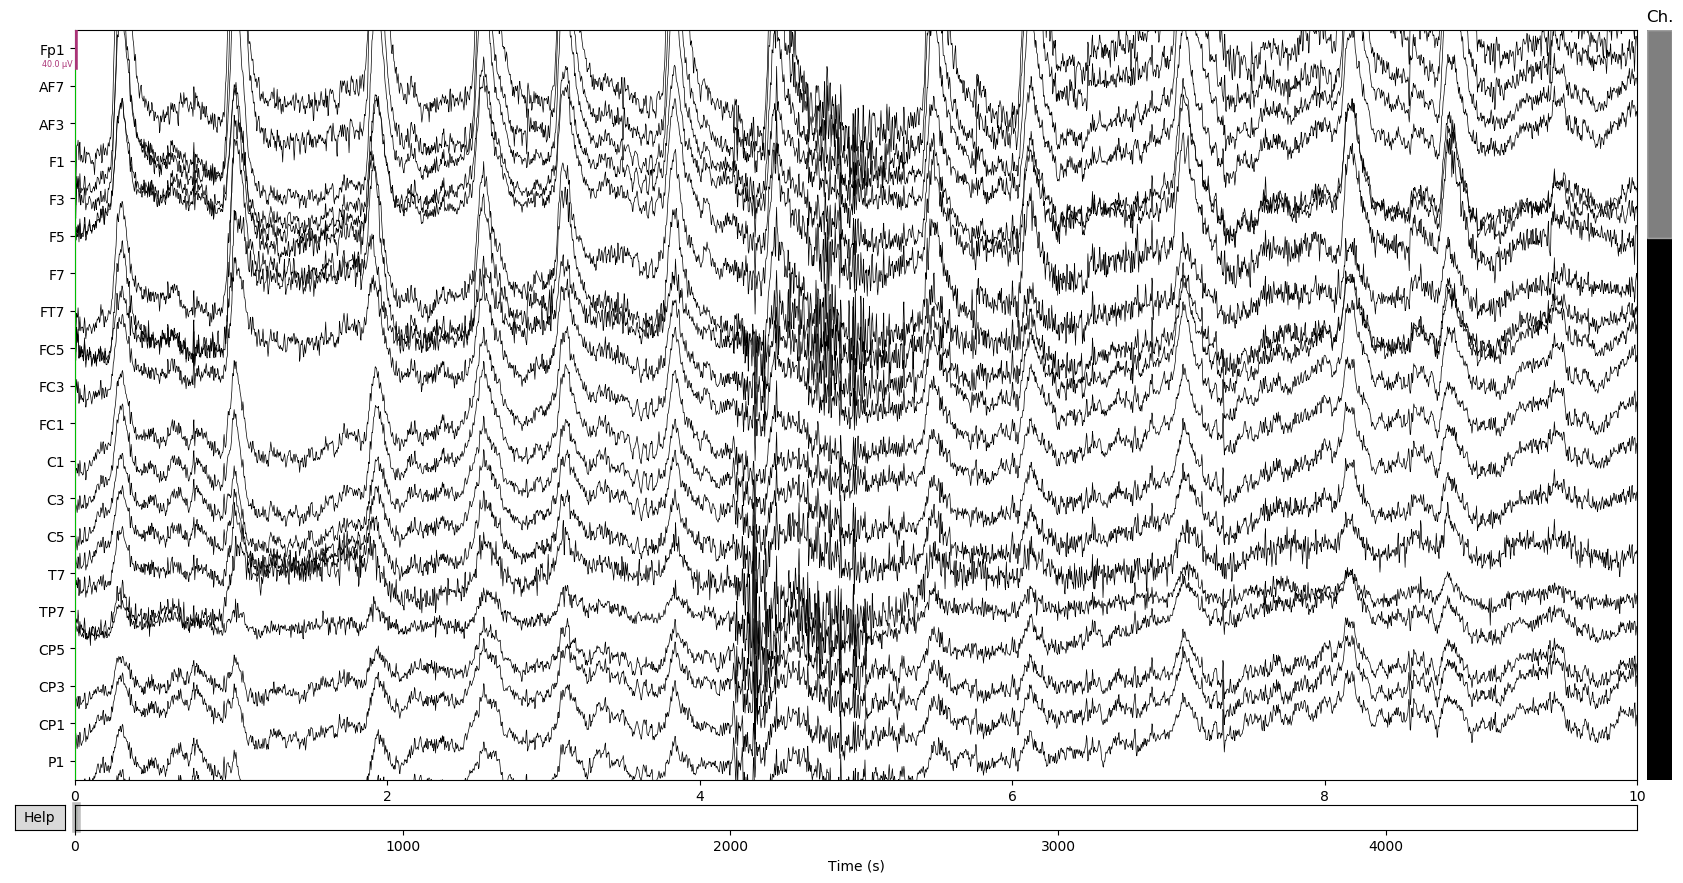

In [8]:
%matplotlib qt
raw.plot()

Notes : 
- RAS

In [9]:
raw.info['bads']

[]

I save the data, hence saving the montage, the low-pass filtered data, the annotation of the bad channel (but none for this subject)

Additionally I re-reference to average as EXG8 is particularly noisy making artifact detection difficult.

In [10]:
raw.set_eeg_reference('average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


<RawEDF | S7.bdf, 72 x 4881408 (4767.0 s), ~2.62 GB, data loaded>

In [11]:
raw.save("%s/pre_rejection_%s.fif"%(name_subj,name_subj),overwrite=True) #sauvegarde les données au format fif pour la suite des traitements

Writing /media/gabriel/DATA/ForceEEG/processing_EEG/S7/pre_rejection_S7.fif


<ipython-input-11-e39f8df35fab>:1: RuntimeWarning: This filename (/media/gabriel/DATA/ForceEEG/processing_EEG/S7/pre_rejection_S7.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw.save("%s/pre_rejection_%s.fif"%(name_subj,name_subj),overwrite=True) #sauvegarde les données au format fif pour la suite des traitements


Closing /media/gabriel/DATA/ForceEEG/processing_EEG/S7/pre_rejection_S7.fif [done]


# Rejecting artefacts

## For the remaining sections and up to the ICA reconstruction I only work with 1Hz High pass filtered data 

The reason being that annotation marked as bad, if not previously filtered to remove slow drifts, gives crazy ICA results (probably because it then captures a lot of edge artifacts from the drifts occuring between the breaks), plus lightly filtered data and average reference seems to ease the detection of artifact, both visually and with the ICA. But the final data (after reconstruction) will remain filtered at 0.01Hz as we usually do and as is recommended for ERP analysis

In [2]:
raw = mne.io.read_raw_fif("%s/pre_rejection_%s.fif"%(name_subj,name_subj), preload=False)

Opening raw data file S7/pre_rejection_S7.fif...


<ipython-input-2-51b23dce2bfc>:1: RuntimeWarning: This filename (S7/pre_rejection_S7.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw = mne.io.read_raw_fif("%s/pre_rejection_%s.fif"%(name_subj,name_subj), preload=False)


    Range : 0 ... 4881407 =      0.000 ...  4766.999 secs
Ready.


In [3]:
filt_raw = raw.copy().load_data().filter(l_freq=1., h_freq=None) # I filter to ease processing (and problem with BAD_breaks)

Reading 0 ... 4881407  =      0.000 ...  4766.999 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3379 samples (3.300 sec)



### Recovering events

Code to recover EMG markers and to merge force condition trigger and stim trigger (had to send them separately because of the number of bits and the coding scheme).

In [4]:
original_evts = pd.read_csv('../processing_EMG/processed/corrected/%s_corrected_evts.csv'%name_subj)
original_evts.code = [int(x) for x in original_evts.code]
original_evts.chan = [int(x) for x in original_evts.chan]
del original_evts["time"]
resp_id = [200, 100]
stim_id = [111,112,113,121,122,123,211,212,213,221,222,223]
force_id = [1,2]
combined_id = [int(str(x[1]) + str(x[0]))  for x in zip(np.tile(stim_id,2), np.repeat(force_id,len(stim_id)))]

emg_chan = [0,1]


evts = original_evts.values

i = 0
max_trials = np.sum(np.isin(evts[:,1], stim_id))
while i < len(evts)-1:
    while evts[i,1] not in force_id and i < len(evts)-1:
        i += 1
    force_trigger = i
    while evts[i,1] not in stim_id and i < len(evts)-1:
        i += 1
    stim_trigger = i
    if i < len(evts)-1:
        evts[stim_trigger, 1] = int(str(evts[force_trigger, 1]) + str(evts[stim_trigger, 1]))
    i += 1
print(np.sum(np.isin(evts[:,1], stim_id)) == 0)
print(np.sum(np.isin(evts[:,1], combined_id)) == max_trials)
original_evts = original_evts.drop(original_evts.iloc[np.isin(evts[:,1], force_id)].index)

True
True


Saving the extracted events

In [5]:
original_evts.to_csv('%s/events_%s.csv'%(name_subj, name_subj))

Total of trials used in the following code

In [6]:
np.sum(np.isin(original_evts.code.values, combined_id))

2448

Correcting the event file to adapt to MNEs events format and keeping only stimuls and response events

In [7]:
evts = original_evts.values
stim_rep_evts = evts[np.isin(evts[:,1], combined_id) | np.isin(evts[:,1], resp_id) ]
stim_rep_evts[:,2] = stim_rep_evts[:,1]

__FYI__ : visualisation of the course of the trials (y= trigger, x=recorded sample) during the experiment for the subject: 

_stimulus trigger_ = XXXX = Force (1:low, 2:High), SAT (1:Accuracy, 2:Speed), expected response (1:left, 2:Right), contrast (1 - 3)

_response trigger_ = 100 (left) 200 (right)

<ipython-input-8-b319de41a708>:1: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  mne.viz.plot_events(stim_rep_evts);


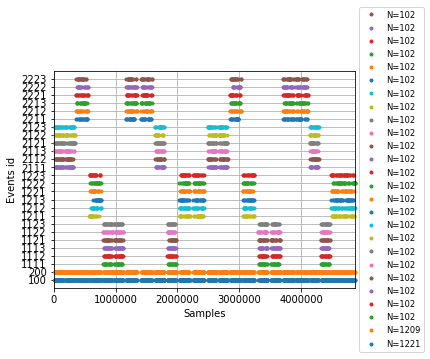

In [8]:
mne.viz.plot_events(stim_rep_evts);

### Detecting and annotating breaks

In the two following cells I mark the period of breaks between the block. I do it because we cannot use these periods in the ICA because they are highly noisy, hence I annotate them and exclude them from the following ICA analysis. I define a break as a duration of more than 20 sec between a response and a stimulus trigger (the duration might be different for other subjects but 20 seconds catches the number of expected breaks)

In [9]:
onset_breaks = stim_rep_evts[np.where(np.diff(stim_rep_evts[:,0], n=1) > (1024*10))][:,0]/1024 #detecting latencies between triggers > 5 sec (searching for the 23 self-paced breaks, and the start of the recording)
offset_breaks = np.flip(np.flip(stim_rep_evts)[np.where(np.diff(np.flip(stim_rep_evts[:,0]), n=1) < -(1024*10))])[:,0]/1024

onset_breaks = onset_breaks + 1 #add 1 sec after last response trigger
offset_breaks = offset_breaks - 1 #removes 1 sec before next stimulus trigger

onset_breaks = np.insert(onset_breaks,0,0)#just adding start of the recording to the breaks
onset_breaks = np.insert(onset_breaks,-1, stim_rep_evts[-1,0]/1024+1)#just adding end of the recording to the breaks

offset_breaks = np.insert(offset_breaks,0,stim_rep_evts[0,0]/1024-1)#just adding start of the recording to the breaks
offset_breaks = np.insert(offset_breaks,-1, raw.times.max())#just adding end of the recording to the breaks



duration_breaks = np.asarray(offset_breaks) - np.asarray(onset_breaks)


print(len(duration_breaks))

25


In [10]:
break_annot = mne.Annotations(onset= np.insert(onset_breaks,0,0),#just adding start of the recording to the breaks
                           duration=np.insert(duration_breaks,0, stim_rep_evts[0,0]/1024-1),
                           description=['BAD_breaks'])
filt_raw.set_annotations(break_annot)

<Raw | pre_rejection_S7.fif, 72 x 4881408 (4767.0 s), ~2.62 GB, data loaded>

## visual artifact rejection

event trigger color code

In [11]:
color_dict = {k:'b' for k in combined_id}
color_dict.update({100:'r', 200:'r'})

Channel order (as we are mainly interesetd with visual latencies I plot the channels from posterior to anterior)

In [12]:
channels = dict(zip(raw.ch_names, np.arange(len(raw.ch_names))))

ch_order= [70,71, 65,66, 27,63,28,26,61,62,29,24,25,60,59,58,57,56,30,19,20,21,22,23,\
           52,53,54,55,31,18,17,16,15,51,50,49,48,47,11,12,13,14,42,43,44,45,46,\
           10,9,8,7,41,40,39,38,37,3,4,5,6,34,35,36,2,1,33,32,0]


### Visualisation window

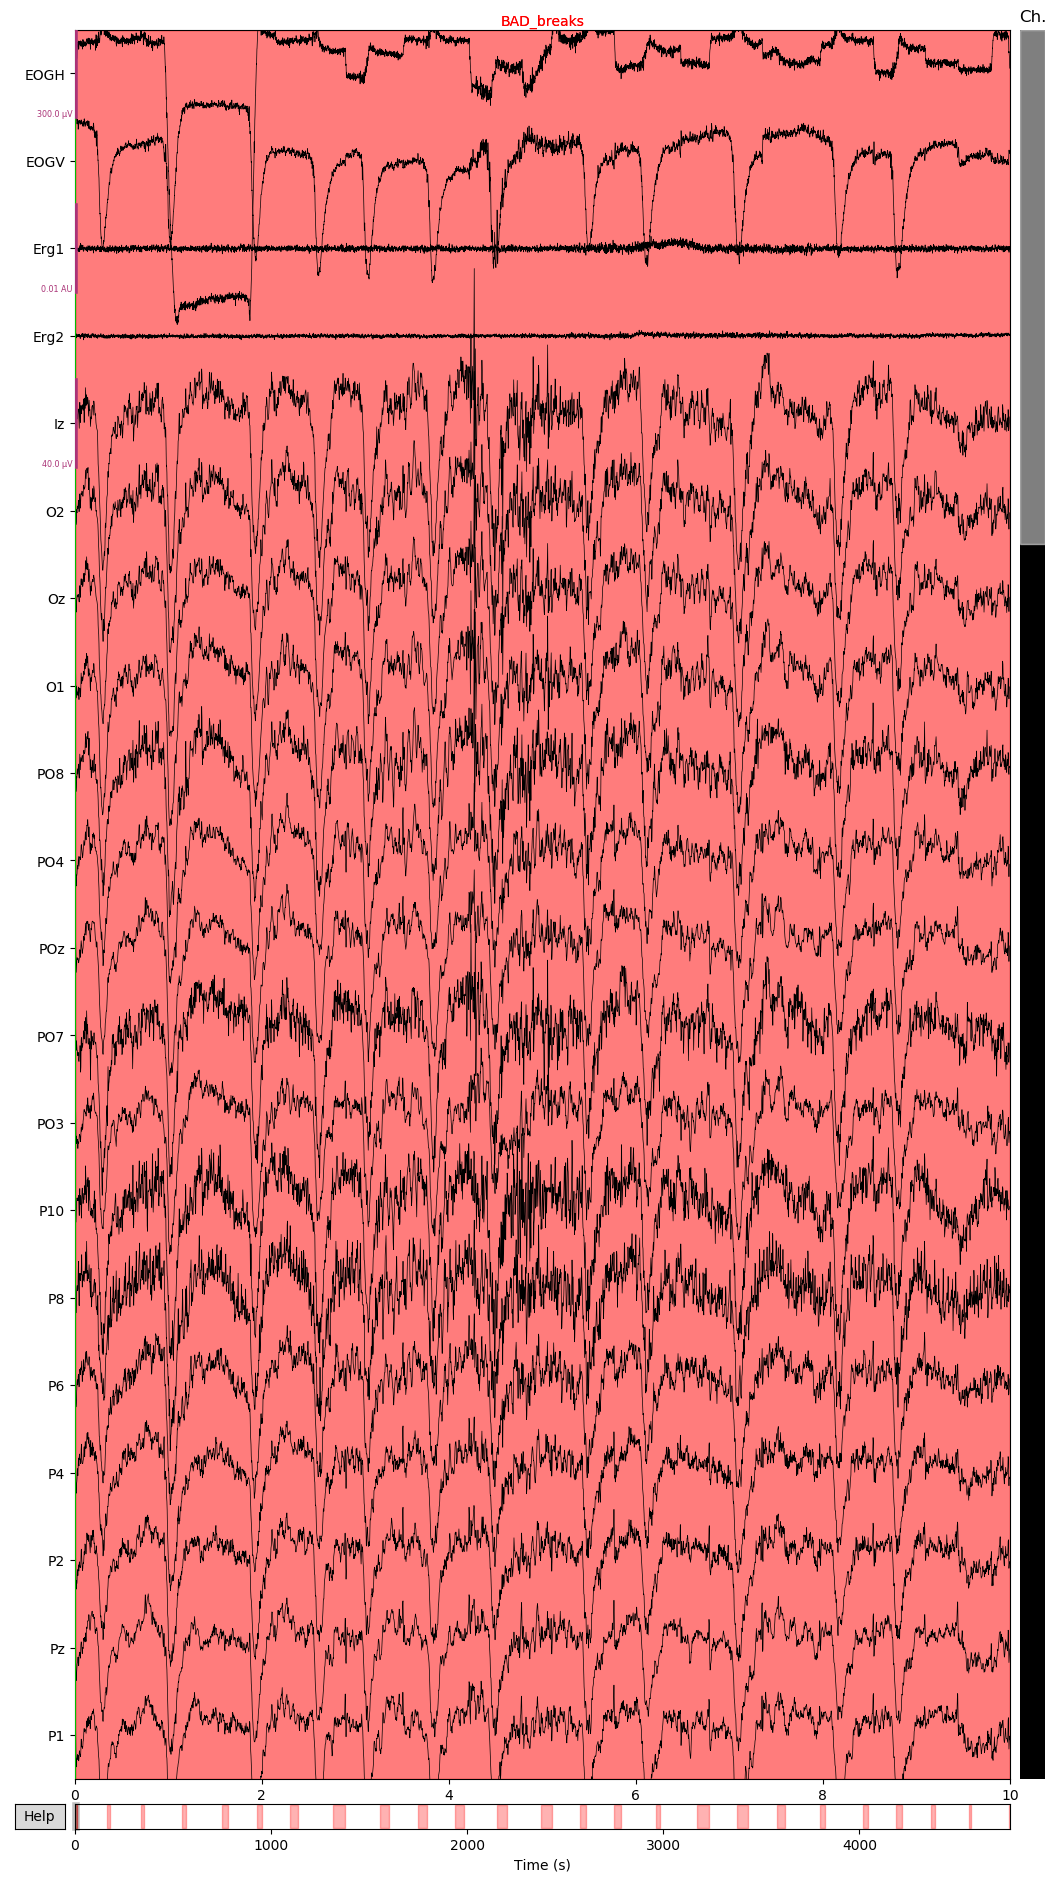

In [14]:
%matplotlib qt

filt_raw.plot(events=stim_rep_evts, event_color=color_dict, remove_dc=True, order=ch_order)

Notes based on raw inspection : 
- FC6 and TP8 periodic noise,
- Recurrent artifact on occipital electrodes, distributed randomly, small EMGlike spikes


Number of annotation + saving

In [15]:
filt_raw.annotations

<Annotations | 95 segments: BAD_ (68), BAD_blink (1), BAD_breaks (26)>

In [16]:
filt_raw.annotations.save('%s/saved_annotations_%s.csv'%(name_subj,name_subj))
#annot_from_file = mne.read_annotations('saved-annotations.csv')
#print(annot_from_file)

Saving the (high-pass filtered) data with the annotations for breaks and artifact

In [17]:
filt_raw.save("%s/pre_ica_%s.fif"%(name_subj,name_subj),overwrite=True)

Writing /media/gabriel/DATA/ForceEEG/processing_EEG/S7/pre_ica_S7.fif


<ipython-input-17-b5f5a09c0b2f>:1: RuntimeWarning: This filename (/media/gabriel/DATA/ForceEEG/processing_EEG/S7/pre_ica_S7.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filt_raw.save("%s/pre_ica_%s.fif"%(name_subj,name_subj),overwrite=True)


Closing /media/gabriel/DATA/ForceEEG/processing_EEG/S7/pre_ica_S7.fif [done]


# Fitting ICA

In [2]:
filt_raw = mne.io.read_raw_fif("%s/pre_ica_%s.fif"%(name_subj,name_subj), preload=True)

Opening raw data file S7/pre_ica_S7.fif...


<ipython-input-2-a412b60167ca>:1: RuntimeWarning: This filename (S7/pre_ica_S7.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filt_raw = mne.io.read_raw_fif("%s/pre_ica_%s.fif"%(name_subj,name_subj), preload=True)


    Range : 0 ... 4881407 =      0.000 ...  4766.999 secs
Ready.
Reading 0 ... 4881407  =      0.000 ...  4766.999 secs...


In [3]:
ica = mne.preprocessing.ICA(max_pca_components = 64-len(filt_raw.info["bads"])-1) #-1 because better when average reference is used (rank)
ica.fit(filt_raw, reject_by_annotation=True, decim=2)
        #I use decim=2 to downsample to 512Hz because ICA eats up a lot of RAM For this subjct I also crop the 3 first block for that reason

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Omitting 1006011 of 4881408 (20.61%) samples, retaining 3875397 (79.39%) samples.
Selecting all PCA components: 63 components
Fitting ICA took 250.3s.


<ICA  |  raw data decomposition, fit (fastica): 1937699 samples, 63 components, channels used: "eeg">

In [4]:
ica.save("%s/ICA_object_%s.fif"%(name_subj,name_subj))

Writing ICA solution to S7/ICA_object_S7.fif...


<ipython-input-4-999a4b462724>:1: RuntimeWarning: This filename (S7/ICA_object_S7.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save("%s/ICA_object_%s.fif"%(name_subj,name_subj))


<ICA  |  raw data decomposition, fit (fastica): 1937699 samples, 63 components, channels used: "eeg">

# Inspecting ICA

__Nota Bene__ : I fitted the ICA on the filtered continuous data, however I want to know how the ICA cleaned the epoched data, hence I inspect the ICA components mainly on the epoched data from the raw data (no low-pass filter other than the one used by biosemi, 0.01 Hz right ?)

In [2]:
raw = mne.io.read_raw_fif("%s/pre_rejection_%s.fif"%(name_subj,name_subj), preload=True)

Opening raw data file S7/pre_rejection_S7.fif...


<ipython-input-2-9ec950cf2067>:1: RuntimeWarning: This filename (S7/pre_rejection_S7.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw = mne.io.read_raw_fif("%s/pre_rejection_%s.fif"%(name_subj,name_subj), preload=True)


    Range : 0 ... 4881407 =      0.000 ...  4766.999 secs
Ready.
Reading 0 ... 4881407  =      0.000 ...  4766.999 secs...


In [3]:
annot_from_file = mne.read_annotations('%s/saved_annotations_%s.csv'%(name_subj,name_subj))
raw.set_annotations(annot_from_file)
print(raw.annotations)

<Annotations | 95 segments: BAD_ (68), BAD_blink (1), BAD_breaks (26)>


In [4]:
ica = mne.preprocessing.read_ica("%s/ICA_object_%s.fif"%(name_subj,name_subj))

Reading S7/ICA_object_S7.fif ...
Now restoring ICA solution ...


<ipython-input-4-c4cd4f34906e>:1: RuntimeWarning: This filename (S7/ICA_object_S7.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica = mne.preprocessing.read_ica("%s/ICA_object_%s.fif"%(name_subj,name_subj))


Ready.


### Visualizing on epochs

In [7]:
trig_id = {'low/speed/left/1':1111,'low/speed/left/2':1112,'low/speed/left/3':1113,
           'low/speed/right/1':1121,'low/speed/right/2':1122,'low/speed/right/3':1123,
           'low/accuracy/left/1':1211,'low/accuracy/left/2':1212,'low/accuracy/left/3':1213,
           'low/accuracy/right/1':1221,'low/accuracy/right/2':1222,'low/speed/accuracy/3':1223,
          'high/speed/left/1':2111,'high/speed/left/2':2112,'high/speed/left/3':2113,
           'high/speed/right/1':2121,'high/speed/right/2':2122,'high/speed/right/3':2123,
           'high/accuracy/left/1':2211,'high/accuracy/left/2':2212,'high/accuracy/left/3':2213,
           'high/accuracy/right/1':2221,'high/accuracy/right/2':2222,'high/speed/accuracy/3':2223,} # used for segmentation

original_evts = pd.read_csv('%s/events_%s.csv'%(name_subj, name_subj), index_col=0)

evts = original_evts.values
evts[:,2] = evts[:,1]

epochs_ica = mne.Epochs(raw, evts, event_id=trig_id, tmin=-0.5, tmax=1, preload=True)

2448 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 2448 events and 1537 original time points ...
127 bad epochs dropped


In [8]:
epochs_ica.resample(500)

<Epochs  |   2321 events (all good), -0.5 - 0.998 sec, baseline [None, 0], ~956.8 MB, data loaded,
 'high/accuracy/left/1': 94
 'high/accuracy/left/2': 100
 'high/accuracy/left/3': 96
 'high/accuracy/right/1': 94
 'high/accuracy/right/2': 90
 'high/speed/accuracy/3': 93
 'high/speed/left/1': 100
 'high/speed/left/2': 102
 'high/speed/left/3': 99
 'high/speed/right/1': 101
 'high/speed/right/2': 99
 'high/speed/right/3': 101
 'low/accuracy/left/1': 97
 'low/accuracy/left/2': 95
 'low/accuracy/left/3': 92
 'low/accuracy/right/1': 95
 'low/accuracy/right/2': 90
 'low/speed/accuracy/3': 93
 'low/speed/left/1': 101
 'low/speed/left/2': 98
 'low/speed/left/3': 101
 'low/speed/right/1': 98
 'low/speed/right/2': 95
 'low/speed/right/3': 97>

### ICs epoch timecourse


In [7]:
%matplotlib qt 
ica.plot_sources(epochs_ica);

Loading data for 2448 events and 1537 original time points ...
127 bad epochs dropped
Loading data for 2321 events and 1537 original time points ...


__Nota Bene__ : epochs are dropped if artifact is in the epoch window

Notes from epoch time course of the ICs : 
- ICA00 blink

- ICA10 High frequency present on  long periods
- IC11 varies a lot in some epochs
- IC13, 29, 36 continuous high frequency noise on/off
- ICA 49, 15, 12, 9, 5,4 have dramatic variation on some epochs
- ICA 19 EMG
- ICA 26 picks up a high share of noise on some portions
- ICA 55 has some 2hz periodic activity


### ICs topomap

In [8]:
ica.plot_components();

Notes on ICs based on topomap  : 
- ICA 000 = blinks
- ICA001 = extrem occipital electrodes, neck EMG ? small spikes as seen on raw ?
- ICA002, 006, 7, 10, 15, 17, 34 = saccades/face EMG
- 19, 21, 23, 28, 29, 43 = EMG
- 9,12 occipital channel noise (Oz,O2)


## Individual ICs inspection

During the next lines I inspect each EOG, EMG or suspicious IC and decide, after the plots of each category, wether to KEEP or to REJECT the IC

### EOG : Checking against recorded EOG (horizontal and vertical)

This section looks at the covariation between the recorded EOG (horizontal and vertical) and the extracted ICs to find those ICs that likely contains eyes artifacts

In [5]:
filt_raw = mne.io.read_raw_fif("%s/pre_ica_%s.fif"%(name_subj,name_subj), preload=True)

eog_indices, eog_scores = ica.find_bads_eog(filt_raw.resample(500))
ica.exclude = eog_indices

Opening raw data file S7/pre_ica_S7.fif...


<ipython-input-5-af9efacd6f55>:1: RuntimeWarning: This filename (S7/pre_ica_S7.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filt_raw = mne.io.read_raw_fif("%s/pre_ica_%s.fif"%(name_subj,name_subj), preload=True)


    Range : 0 ... 4881407 =      0.000 ...  4766.999 secs
Ready.
Reading 0 ... 4881407  =      0.000 ...  4766.999 secs...
Trigger channel has a non-zero initial value of 66304 (consider using initial_event=True to detect this event)
7339 events found
Event IDs: [ 769  770  868  879  880  881  884  885  889  890  891  893  968  979
  980  981  989  990  991 1016 1017 1018 1019]
Trigger channel has a non-zero initial value of 66304 (consider using initial_event=True to detect this event)
7268 events found
Event IDs: [ 769  770  868  879  880  881  885  889  890  891  893  968  979  980
  981  989  990  991 1016 1018 1019]
Omitting 491220 of 2383500 (20.61%) samples, retaining 1892280 (79.39%) samples.
Omitting 491220 of 2383500 (20.61%) samples, retaining 1892280 (79.39%) samples.
Omitting 491220 of 2383500 (20.61%) samples, retaining 1892280 (79.39%) samples.
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a tw

Now I plot the scores, namely the "covariance" between HEOG (top panel), VEOG (lower panel) and the ICs (x axis)

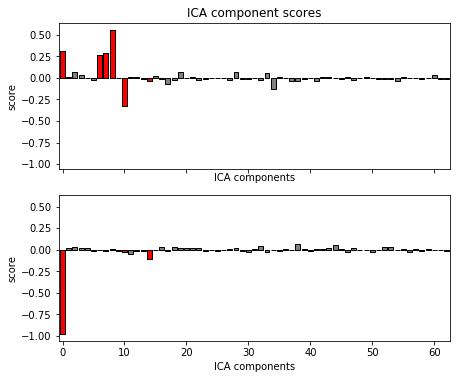

In [6]:
%matplotlib inline 
ica.plot_scores(eog_scores);

MNE's algorithm extracted automatically the following ICs :

In [7]:
eog_indices

[0, 8, 10, 7, 6, 14]

Now I plot for each of these components the topomap; the activity for the created epochs around the stimulus (presentation of the stimuls at 0.2 sec); the spectrum, and the variance of the IC measured at each epoch (watch out the y-axis of this last plot varies a lot across ICs)

    Using multitaper spectrum estimation with 7 DPSS windows
2321 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2321 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2321 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2321 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2321 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2321 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


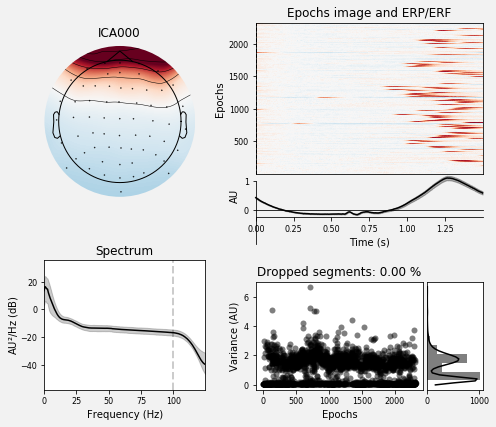

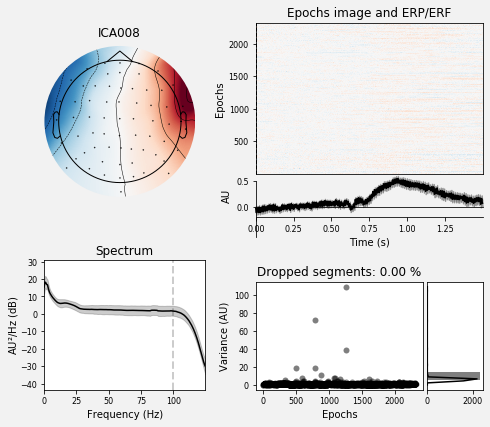

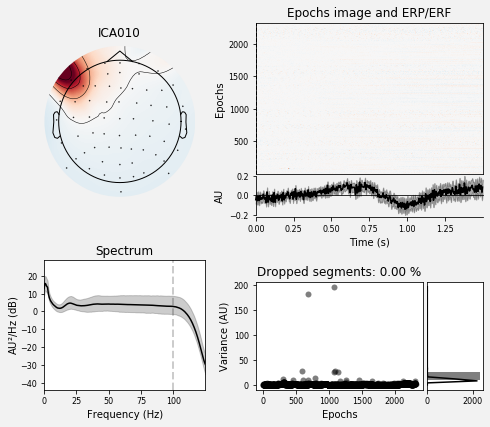

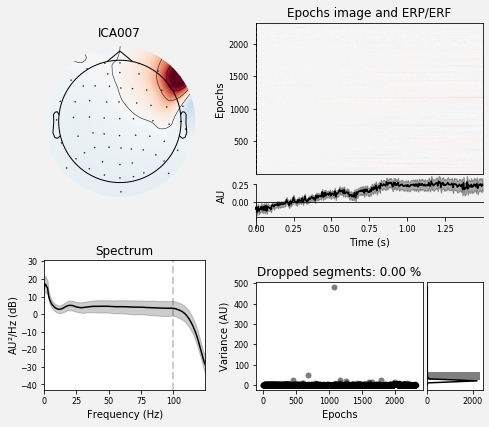

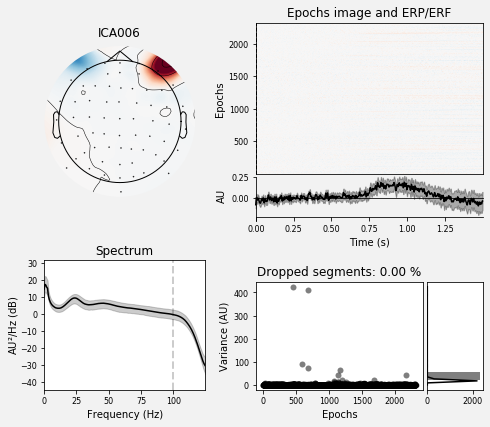

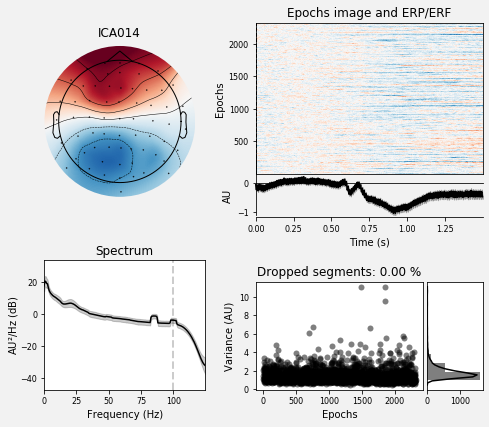

In [9]:
ica.plot_properties(epochs_ica, picks=[0, 8, 10, 7, 6, 14]);

#### Interpretation of the EOG ICs
- ICA000 contains blinks, time course of mean epoch show that participant tends to make blink at end of the trial = REJECT
- ICA 8 has a large dipole, seem to contain stimulus related activity and is only present in few trials KEEP
- IC 6,7,10 = saccades REJECT
- IC 14 has a clear dipole topomap, stimulus related activity, but small peak at 80, 100 Hz, KEEP

In [11]:
ica.exclude = []
eog_comp = [0,6,7,10]

### EMG components

#### Suspected EMG activity from the face

from the notes above the general plot of the ICs (time course and topomap) I look at 2, 15, 17, 34

    Using multitaper spectrum estimation with 7 DPSS windows
2321 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2321 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2321 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2321 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


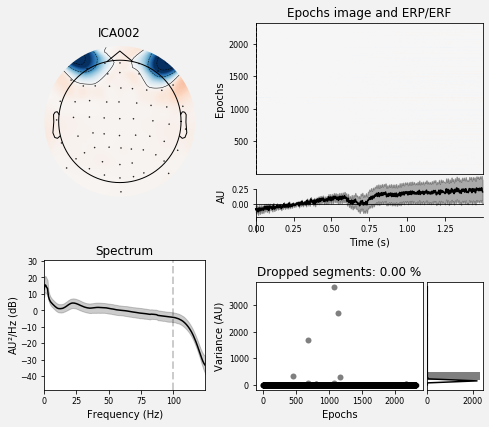

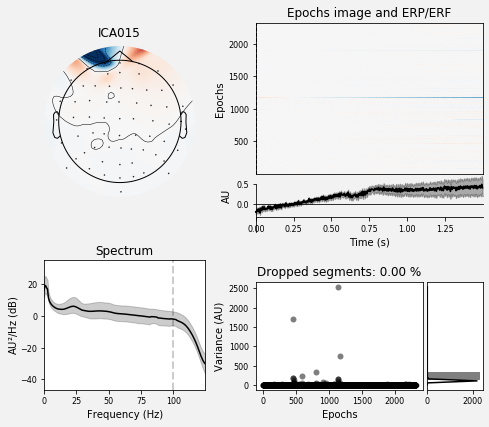

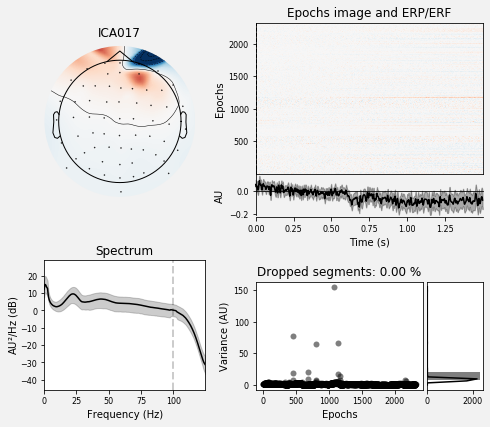

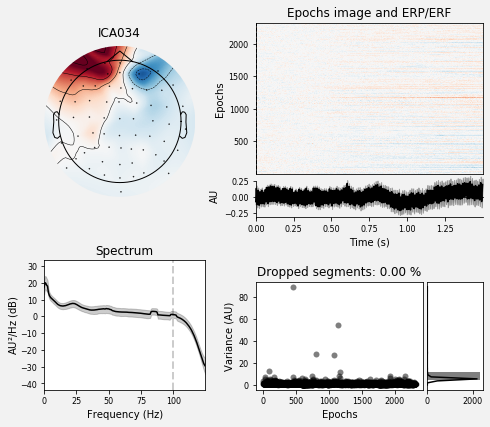

In [10]:
ica.plot_properties(epochs_ica, picks=[2, 15, 17, 34]);

- ICA 2, 15 and 17 peak over 25Hz, has a high variance on some epochs, REJECT
- ICA 34 captures a lot of noise REJECT

In [12]:
face_emg_comp = [2,15,17,34]

#### Other suspected EMGs

From the notes : 19, 21, 23, 28, 29, 43

    Using multitaper spectrum estimation with 7 DPSS windows
2321 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2321 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2321 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2321 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2321 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2321 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


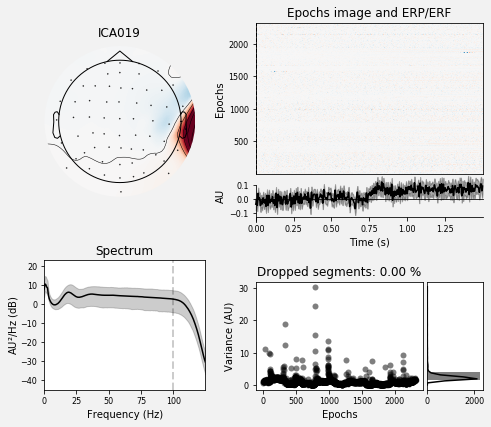

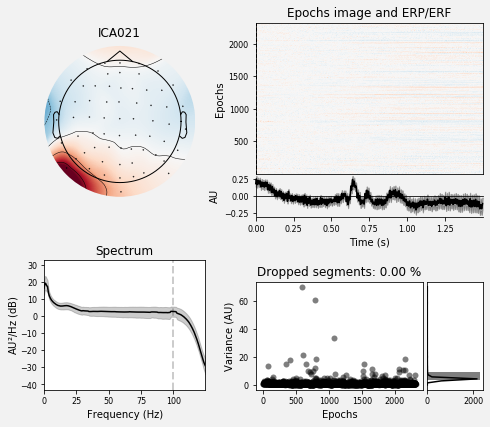

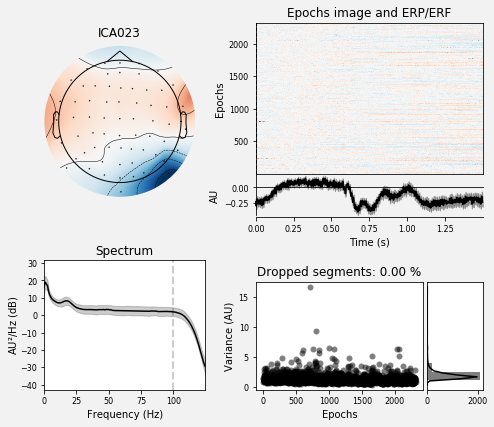

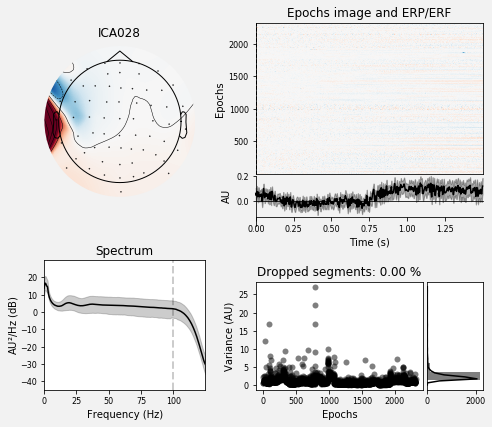

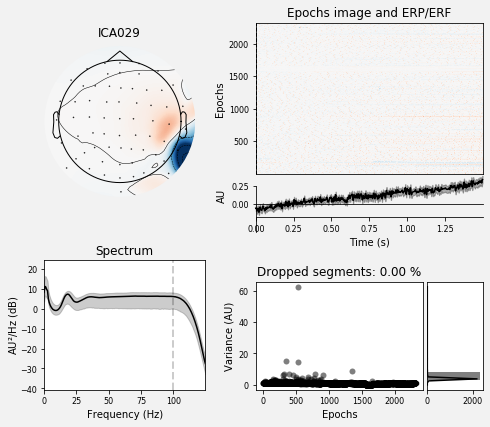

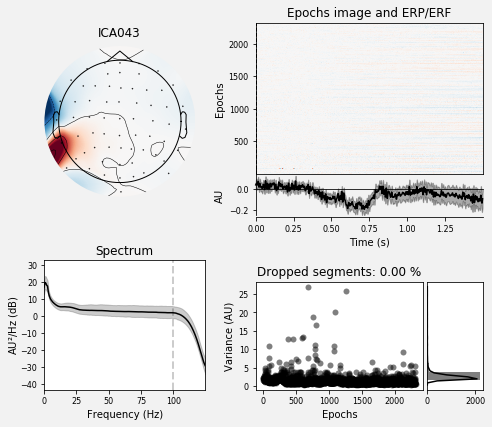

In [13]:
ica.plot_properties(epochs_ica, picks=[19, 21, 23, 28, 29, 43]);

- ICA 19, 28 and 29: neck/face EMG, no stim related activity, present in a lot of trials REJECT
- ICA 21, 23 and 43 : weak evidence for EMG and stim related activity KEEP


In [17]:
other_emg_comp = [19,28,29]

## Other strange components

Notes from epoch time course of the ICs : 

- ICA 55 has some 2hz periodic activity


### ICs topomap

In [8]:
ica.plot_components();

Notes on ICs based on topomap  : 
- ICA 000 = blinks
- ICA001 = extrem occipital electrodes, neck EMG ? small spikes as seen on raw ?
- ICA002, 006, 7, 10, 15, 17, 34 = saccades/face EMG
- 19, 21, 23, 28, 29, 43 = EMG
- 9,12 occipital channel noise (Oz,O2)


based on notes : 4, 5, 9, 11, 12, 13, 26, 36, 49, 55

    Using multitaper spectrum estimation with 7 DPSS windows
2321 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2321 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2321 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2321 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2321 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2321 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2321 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2321 matching events found
No baseli

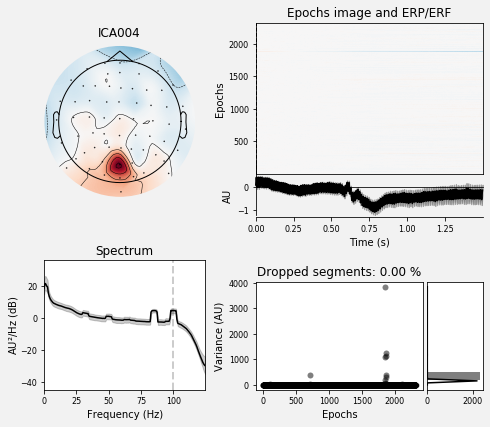

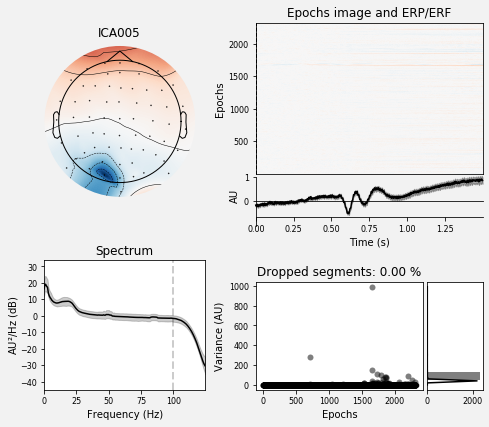

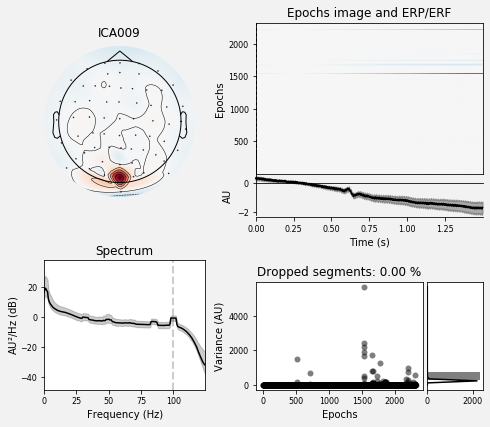

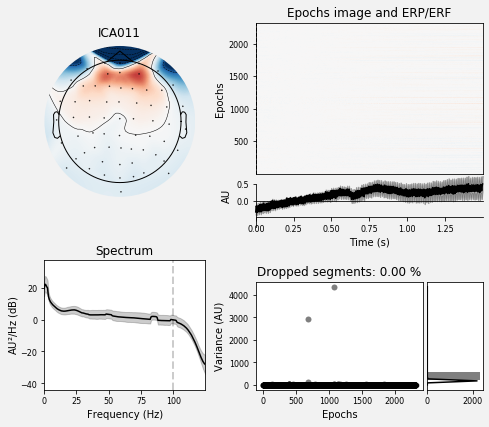

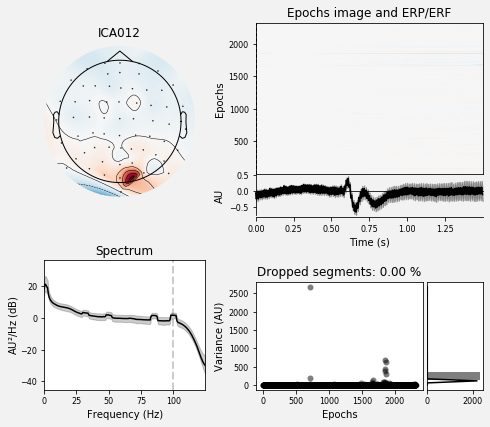

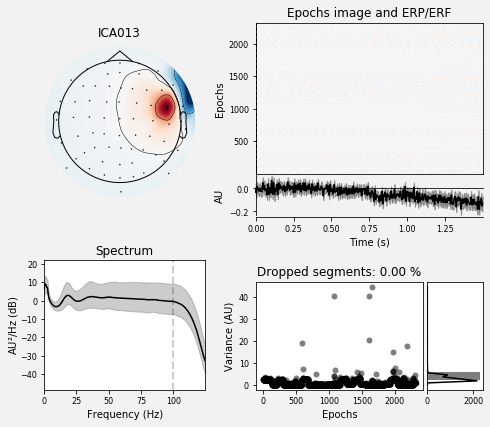

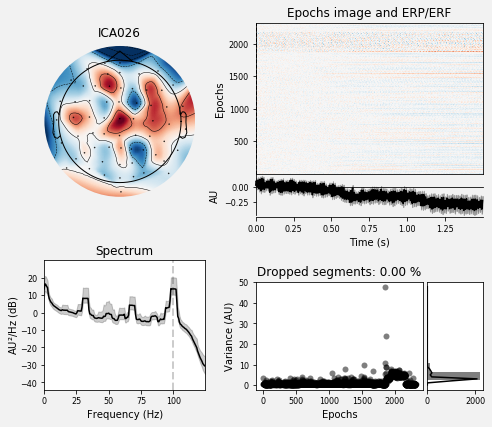

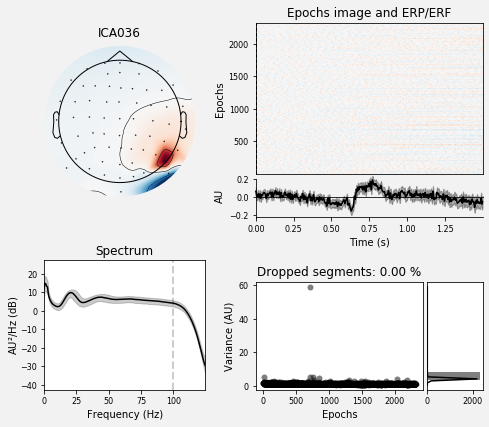

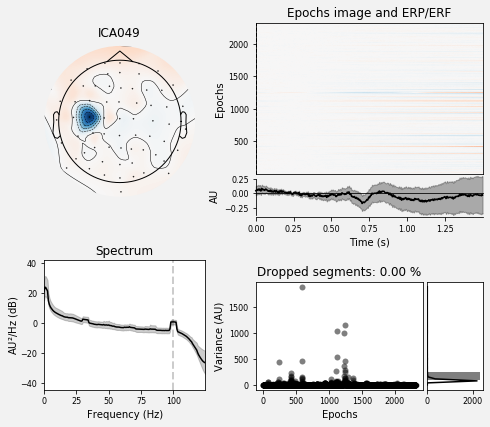

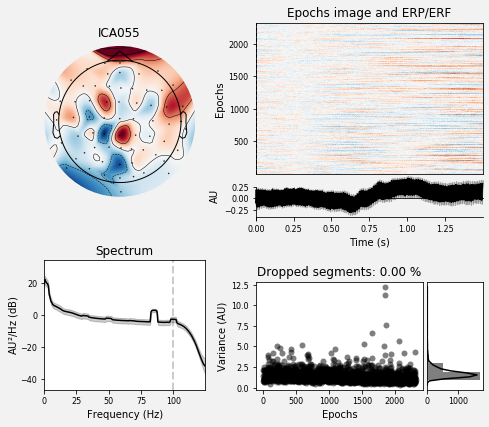

In [14]:
ica.plot_properties(epochs_ica, picks=[4, 5, 9, 11, 12, 13, 26, 36, 49, 55]);

- ICA 4, 12 have peaks at 25, 50, 80 and 100 Hz, are in our ROI, have stim related activity, KEEP
- ICA 5, 49 in our ROI and has stim related activity KEEP
- ICA 9 has peaks at 25, 50, 80 and 100 Hz, is in our ROI, has stim related activity, but present in a non negligeable amount of epochs REJECT
- ICA 11, 13 face related EMG, far from ROI, REJECT
- ICA 26, 55 captures a weird component REJECT
- ICA 36 TP EMG but with stim related activity KEEP



In [15]:
other_comp = [9,11,13,26,55]

## Final exclusions of ICA components :

In [18]:
ica.exclude = eog_comp + face_emg_comp + other_emg_comp + other_comp 
print(ica.exclude)

[0, 6, 7, 10, 2, 15, 17, 34, 19, 28, 29, 9, 11, 13, 26, 55]


In [19]:
ica.apply(raw)


Transforming to ICA space (63 components)
Zeroing out 16 ICA components


<Raw | pre_rejection_S7.fif, 72 x 4881408 (4767.0 s), ~2.62 GB, data loaded>

## Interpolating the bad electrodes after ICA

In [20]:
raw.info['bads']

[]

No electrode to interpolate 

# Saving the final preprocessed data

In [21]:
raw.save("preprocessed_data/preprocessed_%s.fif"%name_subj,overwrite=True) #sauvegarde les données au format fif pour la suite des traitements

Writing /media/gabriel/DATA/ForceEEG/processing_EEG/preprocessed_data/preprocessed_S7.fif


<ipython-input-21-712b88ba4c09>:1: RuntimeWarning: This filename (/media/gabriel/DATA/ForceEEG/processing_EEG/preprocessed_data/preprocessed_S7.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw.save("preprocessed_data/preprocessed_%s.fif"%name_subj,overwrite=True) #sauvegarde les données au format fif pour la suite des traitements


Closing /media/gabriel/DATA/ForceEEG/processing_EEG/preprocessed_data/preprocessed_S7.fif [done]


# Annexe 1: Comparing before/after ICA

Just for illustration puprose I plot the data on the epoch domain befaore and after ICA.

In [5]:
ica.exclude = [0, 6, 7, 10, 2, 15, 17, 34, 19, 28, 29, 9, 11, 13, 26, 55]

raw.resample(sfreq=500) # I resample but just for viz of the difference with/without ICA
reconst_raw = raw.copy()
ica.apply(reconst_raw)



Trigger channel has a non-zero initial value of 66304 (consider using initial_event=True to detect this event)
7339 events found
Event IDs: [ 769  770  868  879  880  881  884  885  889  890  891  893  968  979
  980  981  989  990  991 1016 1017 1018 1019]
Trigger channel has a non-zero initial value of 66304 (consider using initial_event=True to detect this event)
7268 events found
Event IDs: [ 769  770  868  879  880  881  885  889  890  891  893  968  979  980
  981  989  990  991 1016 1018 1019]
Transforming to ICA space (63 components)
Zeroing out 16 ICA components


<Raw | pre_rejection_S7.fif, 72 x 2383500 (4767.0 s), ~1.28 GB, data loaded>

Trigger channel has a non-zero initial value of 66304 (consider using initial_event=True to detect this event)
7268 events found
Event IDs: [ 769  770  868  879  880  881  885  889  890  891  893  968  979  980
  981  989  990  991 1016 1018 1019]
2426 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
2426 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 2426 events and 451 original time points ...
109 bad epochs dropped
Loading data for 384 events and 451 original time points ...
Loading data for 20 events and 451 original time points ...


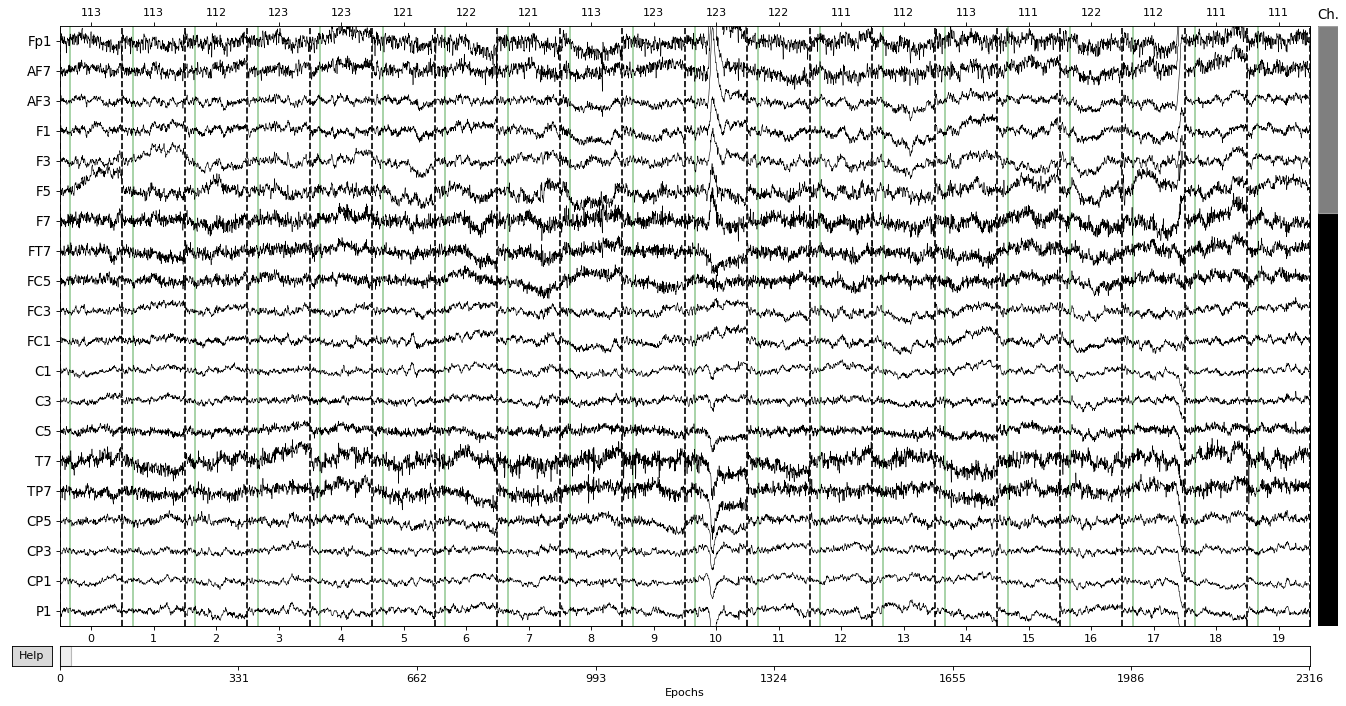

Loading data for 2426 events and 451 original time points ...
109 bad epochs dropped
Loading data for 384 events and 451 original time points ...
Loading data for 20 events and 451 original time points ...


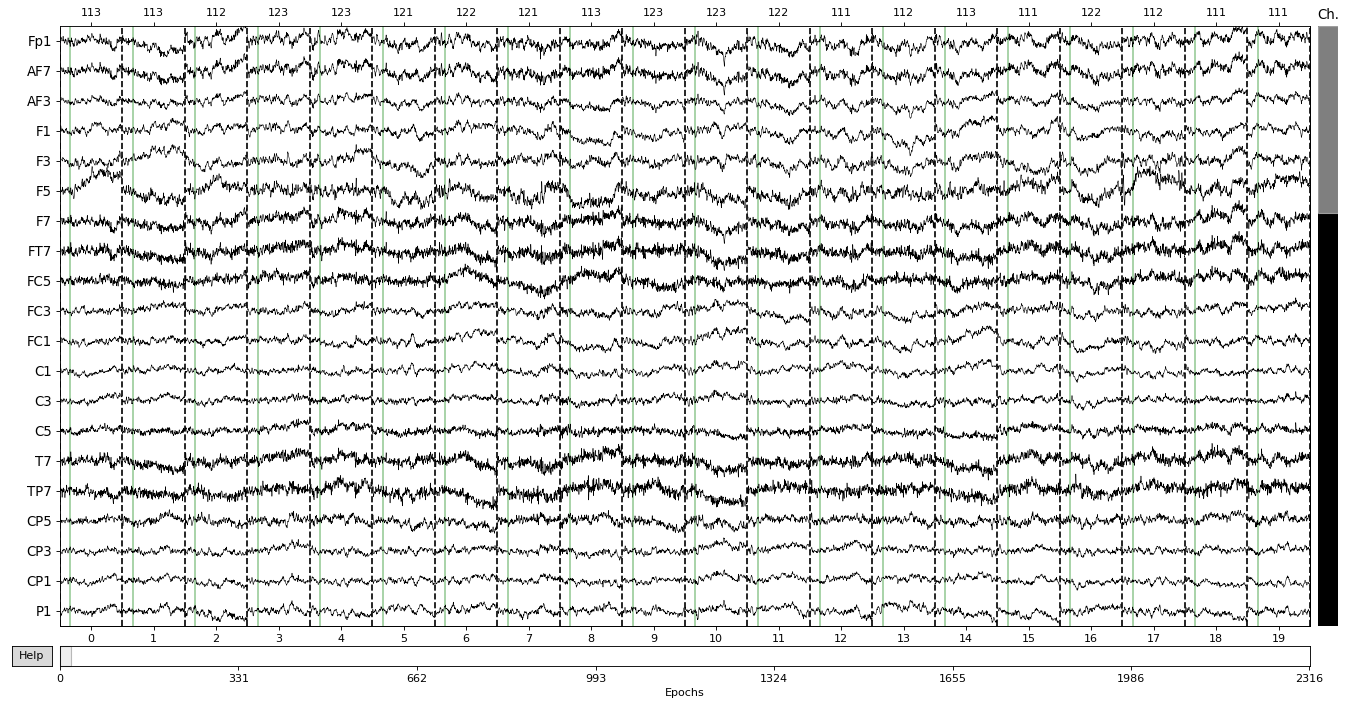

In [7]:
%matplotlib inline
trig_id = {'speed/left/1':111,'speed/left/2':112,'speed/left/3':113,
           'speed/right/1':121,'speed/right/2':122,'speed/right/3':123,
           'accuracy/left/1':211,'accuracy/left/2':212,'accuracy/left/3':213,
           'accuracy/right/1':221,'accuracy/right/2':222,'speed/accuracy/3':223,} # used for segmentation

mne_events = mne.find_events(raw, shortest_event=1)
mne_events[:,2] = mne_events[:,2] - mne_events[:,1]

raw_epochs = mne.Epochs(raw, mne_events, event_id=trig_id, tmin=-0.15, tmax=.75)
reconst_epochs = mne.Epochs(reconst_raw, mne_events, event_id=trig_id, tmin=-0.15, tmax=.75)
raw_epochs.plot(n_epochs=20,scalings = dict(eeg=40e-6), title="Without ICA");
reconst_epochs.plot(n_epochs=20,scalings = dict(eeg=40e-6), title="With ICA");

# Annexe 2: Taking a look at the ERP in monopolar

Again just for illustration purpose I plot the ERP in monopolar (average referenced and low-pass filtered at 30Hz to make pretty plots :-)

In [2]:
raw = mne.io.read_raw_fif("preprocessed_data/preprocessed_%s.fif"%name_subj, preload=True)

Opening raw data file preprocessed_data/preprocessed_S7.fif...


<ipython-input-2-a6e7427b25aa>:1: RuntimeWarning: This filename (preprocessed_data/preprocessed_S7.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw = mne.io.read_raw_fif("preprocessed_data/preprocessed_%s.fif"%name_subj, preload=True)


    Range : 0 ... 4881407 =      0.000 ...  4766.999 secs
Ready.
Reading 0 ... 4881407  =      0.000 ...  4766.999 secs...


In [3]:
raw.filter(None, 30, None,l_trans_bandwidth='auto',filter_length='auto',phase='zero') 


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 451 samples (0.440 sec)



<Raw | preprocessed_S7.fif, 72 x 4881408 (4767.0 s), ~2.62 GB, data loaded>

### Creating epochs

In [4]:
trig_id = {'low/speed/left/1':1111,'low/speed/left/2':1112,'low/speed/left/3':1113,
           'low/speed/right/1':1121,'low/speed/right/2':1122,'low/speed/right/3':1123,
           'low/accuracy/left/1':1211,'low/accuracy/left/2':1212,'low/accuracy/left/3':1213,
           'low/accuracy/right/1':1221,'low/accuracy/right/2':1222,'low/speed/accuracy/3':1223,
          'high/speed/left/1':2111,'high/speed/left/2':2112,'high/speed/left/3':2113,
           'high/speed/right/1':2121,'high/speed/right/2':2122,'high/speed/right/3':2123,
           'high/accuracy/left/1':2211,'high/accuracy/left/2':2212,'high/accuracy/left/3':2213,
           'high/accuracy/right/1':2221,'high/accuracy/right/2':2222,'high/speed/accuracy/3':2223,} # used for segmentation

original_evts = pd.read_csv('%s/events_%s.csv'%(name_subj, name_subj), index_col=0)

evts = original_evts.values
evts[:,2] = evts[:,1]

In [5]:
epochs = mne.Epochs(raw, evts, event_id=trig_id, tmin=-0.3, tmax=.8)

2448 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


### Visualizing contrast on occipital electrodes

Loading data for 816 events and 1127 original time points ...
33 bad epochs dropped
783 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


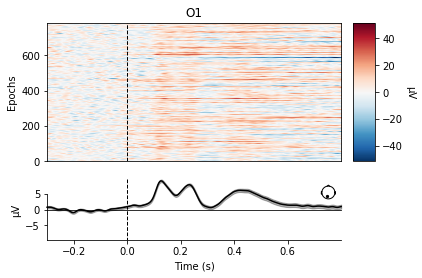

In [6]:
epochs['1'].plot_image(picks=["O1"]);

More than 6 channels, truncating title ...
Loading data for 816 events and 1127 original time points ...
33 bad epochs dropped
783 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


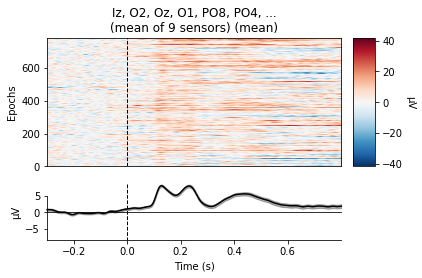

In [7]:
epochs['1'].plot_image(picks=["Iz","O2","Oz","O1", "PO8","PO4","POz","PO3","PO7"],combine="mean");

### looking at the difference between lowest and highest contrast across time and electrodes

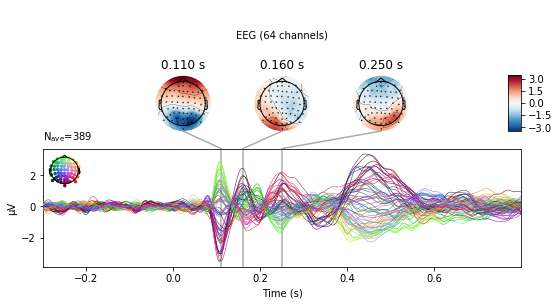

In [11]:
un = epochs["1"].average()
trois = epochs["3"].average()
diff = mne.combine_evoked((un, -trois), weights='equal')
diff.plot_joint(times=[.11,.16,.25]);

### looking at the difference between low and high force across time and electrodes

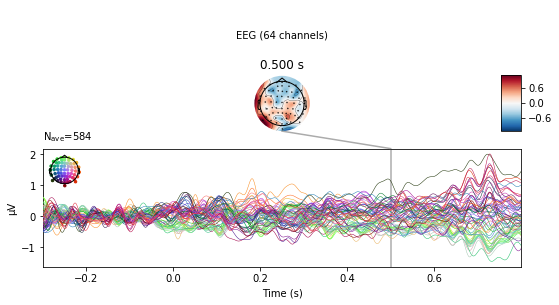

In [12]:
high = epochs["high"].average()
low = epochs["low"].average()
diff = mne.combine_evoked((high, -low), weights='equal')
diff.plot_joint(times=.5);